## À propos de ce tutoriel 

Dans mon article sur la [reconnaissance de chiffres manuscrits avec scikit-learn](https://thedatafrog.com/fr/reconnaissance-decriture-manuscrite-scikit-learn/), nous avons vu qu'avec [scikit-learn](https://scikit-learn.org), il est facile d'entraîner un réseau de neurones simple. Nous avons réussi à reconnaître des images de chiffres avec une précision supérieure à 90%. 

Malheureusement, scikit-learn n'est généralement pas adapté aux réseaux de neurones. 

Son but est en fait de fournir une interface unifiée pour l'entraînement et le test de différents algorithmes de machine learning: réseaux de neurones bien sûr, mais aussi SVM, Bayes, plus proches voisins, arbres de décision, etc. 

En effet, dans un projet de machine learning, on passe une bonne partie de son temps à choisir le bon algorithme et à l'optimiser. Scikit-learn a été conçu pour rendre ces tâches aussi simples et rapides que possible. 

Par contre, pour ce qui est des réseaux de neurones: 

* son interface ne permet pas de créer de réseaux complexes, ni de contrôler leur fonctionnement dans les détails 
* il n'est pas adapté au [deep learning](https://thedatafrog.com/install-tensorflow-windows/)

Dans cet article, nous allons répéter notre exercice sur la reconnaissance de chiffres manuscrits, en utilisant cette fois [Keras](https://keras.io/), un package spécialisé dans les réseaux de neurones. 

Vous apprendrez à:

* Installer Keras
* Créer un réseau de neurones simple avec cet outil
* Estimer les performances de ce réseau

À l'avenir, nous utiliserons Keras comme interface vers TensorFlow pour faire du deep learning. 

**Prérequis:** 

Il faudrait que vous ayez déjà manipulé un réseau de neurones simple et que vous ayez quelques notions de: 

* numpy, 
* matplotlib, 
* jupyter notebook

Si ce n'est pas le cas, le tuto sur la [reconnaissance de chiffres manuscrits avec scikit-learn](https://thedatafrog.com/fr/reconnaissance-decriture-manuscrite-scikit-learn/) est fait pour vous!


## Installation

Installez d'abord [Anaconda](https://www.anaconda.com/download/) si ce n'est pas encore fait. Choisissez bien **la version pour python 2.X, et pas pour python 3.X**.

Lancez l'application Anaconda Navigator. 

Dans l'onglet Environments, sélectionnez l'environnement de base (root), 
et installez-y le package keras. Anaconda peut mettre plusieurs minutes à installer ce package, soyez patient.

Ensuite, allez dans l'onglet Home pour lancer jupyter notebook. 

Enfin, récupérez ce notebook, et ouvrez-le dans jupyter notebook.

* [téléchargez le dépôt contenant ce notebook](https://github.com/cbernet/maldives/archive/master.zip)
* décompressez-le, par exemple dans `Downloads/maldives-master`
* dans jupyter notebook, naviguez vers `Downloads/maldives-master/handwritten_digits_keras`
* ouvrez `handwritten_digits_keras_fr.ipynb`

Cette page devrait apparaître dans le notebook. À partir de maintenant, vous pouvez suivre ce tutoriel dans le notebook. 

## Préparation de l'échantillon de données

Comme dans [reconnaissance de chiffres manuscrits avec scikit-learn](https://thedatafrog.com/fr/reconnaissance-decriture-manuscrite-scikit-learn/), nous allons utiliser l'échantillon de chiffres fourni avec scikit-learn. Les chiffres sont des images 8x8, et nous allons les traiter avec un réseau de neurones avec: 

* une couche d'entrée avec 8x8 = 64 neurones 
* une couche cachée de 15 neurones 
* une couche de sortie de 10 neurones, correspondant aux dix catégories de chiffres. 

D'abord, initialisons nos outils et chargeons l'échantillon:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
# for some reason, the following 
# is needed to run on mac os X
os.environ['KMP_DUPLICATE_LIB_OK']='True'  

from sklearn import datasets
digits = datasets.load_digits()

La couche d'entrée requiert un tableau 1D de 64 valeurs, mais nos images sont 2D, avec 8x8 pixels. Nous devons donc les sérialiser:

In [2]:
x = digits.images.reshape((len(digits.images), -1))
x.shape

(1797, 64)

De plus, un peu de travail est nécessaire avant de pouvoir utiliser les étiquettes. 

Pour l'instant, `digits.target` contient le chiffre auquel correspond chaque image dans l'échantillon:

In [3]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

Mais avec Keras, nous devons construire un réseau avec 10 neurones de sortie. C'est aussi le cas avec scikit-learn, bien que ce soit caché à l'utilisateur. Au cours de l'entraînement, Keras devra comparer les 10 valeurs de sortie de ces neurones à l'étiquette pour donner un retour au réseau et lui permettre de s'améliorer. Mais comment pouvons nous comparer un tableau de 10 valeurs à une seule valeur, celle de l'étiquette?

La solution est de traduire chaque étiquette en un tableau de taille 10 (une technique appelée *one-hot encoding*): 

* la valeur `0` donne `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`
* `1` donne `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`
* ...
* `9` donne `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`

Après cela, les valeurs des 10 neurones de sortie, qui sont des probabilités entre 0 et 1, peuvent être directement comparées aux 10 valeurs de l'étiquette. 

De cette façon, pour un chiffre donné, par exemple 0, le réseau de neurones sera entraîné à donner une probabilité élevée sur le premier neurone de sortie, et une faible probabilité sur les neurones suivants. 

Cet encodage se fait facilement avec les outils fournis par Keras: 

In [4]:
from keras.utils import np_utils
y = np_utils.to_categorical(digits.target,10)
print digits.target
print y

Using TensorFlow backend.


[0 1 2 ... 8 9 8]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


Nous pouvons maintenant partager nos données entre un échantillon d'entraînement et un échantillon de test:

In [5]:
split_limit=1000
x_train = x[:split_limit]
y_train = y[:split_limit]
x_test = x[split_limit:]
y_test = y[split_limit:]

Les 1000 premières images et étiquettes seront utilisées pour l'entraînement, et les suivantes pour l'évaluation des performances de notre réseau.

## Création du réseau de neurones avec Keras

Après avoir importé les outils nécessaires, créons le réseau de neurones. 

In [6]:
from keras import layers, Model, optimizers, regularizers

In [7]:
# Création de la couche d'entrée
# 
# On spécifie que cette couche doit 
# avoir 64 neurones, un pour chaque 
# pixel dans nos images. 
# Les neurones d'entrée ne font rien, 
# ils se contentent de transférer la 
# valeur sur chaque pixel à la couche 
# suivante.
img_input = layers.Input(shape=(64,))


# Création de la couche cachée
#
# Cette couche est dense, ce qui veut 
# dire que chacun de ses neurones est 
# connecté à tous les neurones de la 
# couche précédente (la couche d'entrée).
# Nous parlerons de l'activation dans un
# futur post.
tmp = layers.Dense(15, 
                   activation='sigmoid')(img_input)

# Création de la couche de sortie
# 
# La couche de sortie est dense également. 
# Elle doit avoir 10 neurones, correspondant
# aux 10 catégories de chiffres. 
output = layers.Dense(10, 
                      activation='sigmoid')(tmp)

# Création du réseau de neurones 
# à partir des couches
model = Model(img_input, output)

# Impression d'une description du réseau
model.summary()

# =================================================
# Merci de pas prêter attention à cette partie. 
# Nous parlerons de la régularisation plus tard.
# Pour l'instant, il suffit de noter que la 
# régularisation aide le réseau à converger 
# correctement. 
# J'ai rajouté cette régularisation ici car elle 
# est effectuée par défaut dans scikit-learn,  
# et que nous voulons pouvoir comparer les résultats
# de keras et scikit-learn. 
l2_rate = 1e-4
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = regularizers.l2(l2_rate)
        layer.bias_regularizer = regularizers.l2(l2_rate)
        layer.activity_regularizer = regularizers.l2(l2_rate)
# =================================================

# Définition de la méthode d'apprentissage, 
# et compilation du modèle.
# 
# Le modèle doit être compilé pour être 
# entraîné et utilisé. 
# Les arguments loss, optimizer, et metric
# seront couverts dans un futur post. 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.1, momentum=0.9),
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                975       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
Total params: 1,135
Trainable params: 1,135
Non-trainable params: 0
_________________________________________________________________


Finalement, nous pouvons entraîner le réseau:

In [8]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test),
                    batch_size=100, epochs=50)

Train on 1000 samples, validate on 797 samples
Epoch 1/50
1000/1000 [==============================] - 0s 466us/step - loss: 2.2659 - acc: 0.1090 - val_loss: 2.1448 - val_acc: 0.2560
Epoch 2/50
1000/1000 [==============================] - 0s 25us/step - loss: 2.0436 - acc: 0.4730 - val_loss: 1.9326 - val_acc: 0.6035
Epoch 3/50
1000/1000 [==============================] - 0s 39us/step - loss: 1.8035 - acc: 0.6970 - val_loss: 1.6691 - val_acc: 0.7327
Epoch 4/50
1000/1000 [==============================] - 0s 32us/step - loss: 1.4918 - acc: 0.7700 - val_loss: 1.3363 - val_acc: 0.7992
Epoch 5/50
1000/1000 [==============================] - 0s 44us/step - loss: 1.1356 - acc: 0.8410 - val_loss: 1.0526 - val_acc: 0.8030
Epoch 6/50
1000/1000 [==============================] - 0s 44us/step - loss: 0.8624 - acc: 0.8750 - val_loss: 0.8443 - val_acc: 0.8444
Epoch 7/50
1000/1000 [==============================] - 0s 52us/step - loss: 0.6668 - acc: 0.9070 - val_loss: 0.6984 - val_acc: 0.8469
Epoch 8

## Évaluation des performances

Les prédictions du réseau de neurones sont évaluées pour tous les exemples de l'échantillon de test: 

In [9]:
predictions = model.predict(x_test)
print predictions[3]

[4.1344309e-05 7.1412884e-05 1.0588833e-05 4.5387871e-05 6.5384602e-06
 1.2550692e-01 5.3597946e-06 7.5986383e-05 1.1356127e-04 8.0707548e-05]


Pour chaque exemple, la prédiction est un tableau de 10 valeurs. Chaque valeur est la probabilité, estimée par le réseau, que l'image appartienne à une catégorie donnée. 

La catégorie prédite est celle avec la probabilité la plus grande.  

Écrivons maintenant une petite fonction pour afficher une image donnée, et imprimer la catégorie prédite ainsi que la catégorie réelle:

In [10]:
def plot_prediction(index):
    print 'predicted probabilities:'
    print predictions[index]
    print 'predicted category', np.argmax(predictions[index])
    print 'true probabilities:'
    print y_test[index]
    print 'true category', np.argmax(y_test[index])
    img = x_test[index].reshape(8,8)
    plt.imshow(img)

Dans cette fonction, on obtient la catégorie avec `np.argmax` qui, pour un tableau, retourne l'index correspondant à la valeur maximum. 

Utilisons cette fonction pour regarder quelques exemples (changez juste l'index pour choisir un autre exemple):

predicted probabilities:
[4.1344309e-05 7.1412884e-05 1.0588833e-05 4.5387871e-05 6.5384602e-06
 1.2550692e-01 5.3597946e-06 7.5986383e-05 1.1356127e-04 8.0707548e-05]
predicted category 5
true probabilities:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
true category 5


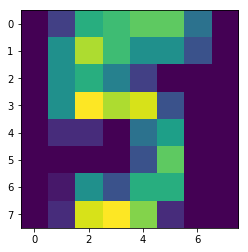

In [11]:
plot_prediction(3)

Enfin, calculons la précision, c'est à dire la probabilité de classer les chiffres correctement. 

On calcule cette précision sur l'échantillon de test, qui n'a pas été utilisé dans l'entraînement du réseau. À nouveau, on utilise `np.argmax` pour obtenir les catégories vraies et prédites pour chaque exemple. 

In [12]:
# Le deuxième argument de argmax spécifie
# que l'on souhaite conserver la première 
# dimension du tableau. 
# Ainsi, argmax est calculé pour chaque 
# exemple. 
# Sans cet argument, argmax retournerait
# une seule valeur, la probabilité maximum 
# dans le tableau complet, 
# en considérant l'ensemble des exemples 
y_test_best = np.argmax(y_test,1)
print y_test_best.shape
predictions_best = np.argmax(predictions,1)

from sklearn.metrics import accuracy_score
accuracy_score(y_test_best, predictions_best)

(797,)


0.9134253450439147

Vous devriez obtenir une précision autour de 91%, similaire à celle que nous avons obtenue dans les mêmes conditions avec scikit-learn. 

Le résultat n'est pas reproductible, et la précision variera à chaque fois que vous ré-entraînerez un nouveau réseau. Personnellement, j'obtiens généralement une précision entre 90 et 93%.  

Et pour vous, que se passe-t'il lorsque vous répétez l'exercice? 

## Et ensuite? 

Dans ce post, vous avez entraîné votre premier réseau de neurones avec keras.  

Keras est un outil incontournable, et nous l'utiliserons régulièrement sur ce blog. 

Très bientôt, nous nous lancerons dans le deep learning sur GPU avec keras et TensorFlow. 

Pour en savoir plus: [Guide to the sequential model of keras](https://keras.io/getting-started/sequential-model-guide/)